In [1]:
import pandas as pd
import numpy as np
import gzip
from collections import defaultdict
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer,text_to_word_sequence

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
vocab_size = 400000
embedding_size = 50
maxlen = 10
#embeddings_path = 'glove.6B.50d.txt.gz'
embeddings_path = './98_data/glove/glove.6B.50d.txt'

In [3]:
import pandas as pd
from sklearn.cross_validation import train_test_split

df = pd.read_excel('./98_data/qalist_answer.xlsx', encoding='latin-1')
df.columns=['Emails','Cat']
df = df[pd.notnull(df['Emails'])]
train, test  = train_test_split( df, test_size=0.20, random_state=10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
train.shape

(16262, 2)

In [5]:
test.shape

(4066, 2)

In [6]:
train.head()

,Emails,Cat
6473,I could not The field engagement_code is chang...,The system bug and it is working now after app...
13849,The following issue was encountered. The field...,The system bug and it is working now after app...
13758,The following issue was encountered. The field...,The system bug and it is working now after app...
16758,Does anyone know how to solve The field employ...,"The system setting is missing, and it is corre..."
19780,The error messges comes out when I inputted my...,"The system maintenance was completed, and it i..."


In [29]:
# Common methods to read data and get embeddings
def read_data():
    df_train = train
    df_val = test
    categories = list(set(df_train.Cat.values))
    return df_train,df_val,categories

def load_embeddings():
    word_index = {}
    embeddings = np.zeros((vocab_size,embedding_size))
    #with gzip.open(embeddings_path) as file:
    with open(embeddings_path) as file:
        for i,line in enumerate(file):
            if i<vocab_size:
                line_tokens = line.split()
                word=line_tokens[0]
                #word = line_tokens[0].decode(encoding='UTF-8')
                embeddings[i] = np.asarray(line_tokens[1:],dtype='float32')
                word_index[word] = i
    file.close()
    return embeddings,word_index

In [30]:
def get_embedding(word,word_index,embeddings):
    if word in word_index:
        return embeddings[word_index[word]].reshape(((embedding_size,1)))
    else:
        return np.zeros((embedding_size,1))

In [31]:
# Methods for Neural Network Model
def prepare_data(df_train,df_val,categories):
    train_text = df_train['Emails'].tolist()
    val_text = df_val['Emails'].tolist()
    tk = Tokenizer(num_words = vocab_size, lower = True)
    tk.fit_on_texts(train_text + val_text)
    x_train = pad_sequences(tk.texts_to_sequences(train_text),maxlen=maxlen)
    x_val = pad_sequences(tk.texts_to_sequences(val_text),maxlen=maxlen)
    y_train = category_to_one_hot(df_train['Cat'].values,categories)
    y_val = category_to_one_hot(df_val['Cat'].values,categories) 
    return tk.word_index,x_train,y_train,x_val,y_val

def prepare_data_from_full_word_index(df_train,df_val,categories,word_index):
    train_text = df_train['Emails'].tolist()
    val_text = df_val['Emails'].tolist()
    x_train = get_pad_sequences(train_text,word_index)
    x_val = get_pad_sequences(val_text,word_index)
    y_train = category_to_one_hot(df_train['Cat'].values,categories)
    y_val = category_to_one_hot(df_val['Cat'].values,categories) 
    return word_index,x_train,y_train,x_val,y_val

def get_pad_sequences(text_list,word_index):
    seqs = []
    for text in text_list:
        word_seq = text_to_word_sequence(text.lower())
        seq = []
        for word in word_seq:
          if word in word_index:
            seq.append(word_index[word])
        seqs.append(seq)
    return pad_sequences(seqs,maxlen)


# Convert the list of categories to one_hot vector
def category_to_one_hot(cat_list,cat_master):
    cat_dict = {}
    for i,cat in enumerate(cat_master):
        cat_dict[cat] = i
    cat_integers = [cat_dict[cat] for cat in cat_list]
    return to_categorical(cat_integers,num_classes=len(cat_master))

# Convert one_hot to category
def one_hot_to_category(cat_one_hot_list,cat_master):
    return [cat_master[cat_one_hot.argmax()] for cat_one_hot in cat_one_hot_list]

# Get the embedding weights for the model
def get_embedding_matrix_for_model(embeddings,word_index):
    train_val_words = min(vocab_size, len(word_index)) +1
    embedding_matrix = np.zeros((train_val_words, embedding_size))
    for word, i in word_index.items():
        embedding_vector = get_embedding(word,word_index,embeddings).flatten()
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Build the keras model
def build_model(embedding_matrix,categories):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_size, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model.add(LSTM(32))
#   We don't lose much by replacing LSTM with this flatten layer (as we have short sequences)
#   model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(categories), activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
    return model

def get_val(numerator,divisor):
    return float('nan') if divisor == 0 else np.round(numerator/divisor,3)

def analyze_predictions(categories,y_true,y_pred):
    tp = defaultdict(int)
    tn = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)
    precisions = []
    recalls = []
    f1s = []
    cat_counts = defaultdict(int)
    for cat in y_true:
        cat_counts[cat]+=1 
    correct = 0
    conf_mat = defaultdict(dict)
    for cat1 in categories:
        for cat2 in categories:
            conf_mat[cat1][cat2] = 0
    for y,y_hat in zip(y_true,y_pred):
        conf_mat[y][y_hat]+=1
        if y == y_hat:
            correct+=1
            tp[y]+=1
        else:
            fp[y_hat]+=1
            fn[y]+=1
    print('Overall Accuracy:',round(correct/len(y_pred),3))
    for cat in categories:
        precision = get_val(tp[cat],tp[cat]+fp[cat])
        recall = get_val(tp[cat],(tp[cat]+fn[cat]))
        f1 = get_val(2*precision*recall,precision + recall)
        precisions.append(precision)
        recalls.append(recall)  
        f1s.append(f1)
        print('{} --> Precision:{},Recall:{},F1:{}'.format(cat,precision,recall,f1))
    print ('\nAverages---> Precision:{}, Recall:{}, F1:{}'.format(np.round(np.nanmean(precisions),3),                                                                                                np.round(np.nanmean(recalls),3),
                                                               np.round(np.nanmean(f1s),3))
          )
          
    print('\nConfusion Matrix')
    for cat1 in categories:
        print('\n'  +cat1+'({}) --> '.format(cat_counts[cat1]),end='')
        for cat2 in categories:
            print('{}({})'.format(cat2,conf_mat[cat1][cat2]),end=' , ')
    print('')
    


# From Deep Learning with Python book
def make_history_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', color='green',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', color='green',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [32]:
import numpy as np
np.random.seed(42) # for reproducibility
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
df_train,df_val,categories = read_data()

In [34]:
#Load Glove 50-d embeddings
embeddings,word_index = load_embeddings()

In [35]:
#Prepare the data for the model
tk_word_index,x_train,y_train,x_val,y_val = prepare_data_from_full_word_index(df_train,df_val,categories,word_index)

In [36]:
# Get the embedding matrix for the model, build model, display model summary
embedding_matrix = get_embedding_matrix_for_model(embeddings,word_index)
model = build_model(embedding_matrix,categories)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 20,011,994
Trainable params: 11,944
Non-trainable params: 20,000,050
_________________________________________________________________


In [37]:
# Train the model, record history
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=24,
                    shuffle=False,
                    validation_data=(x_val, y_val))

Train on 16262 samples, validate on 4066 samples
Epoch 1/5
16262/16262 [==============================] - 8s 468us/step - loss: 0.6036 - acc: 0.7758 - val_loss: 0.2042 - val_acc: 0.9208
Epoch 2/5
16262/16262 [==============================] - 7s 427us/step - loss: 0.1702 - acc: 0.9314 - val_loss: 0.1751 - val_acc: 0.9211
Epoch 3/5
16262/16262 [==============================] - 7s 436us/step - loss: 0.1604 - acc: 0.9322 - val_loss: 0.1688 - val_acc: 0.9302
Epoch 4/5
16262/16262 [==============================] - 7s 431us/step - loss: 0.1585 - acc: 0.9334 - val_loss: 0.1661 - val_acc: 0.9302
Epoch 5/5
16262/16262 [==============================] - 7s 430us/step - loss: 0.1569 - acc: 0.9355 - val_loss: 0.1696 - val_acc: 0.9292


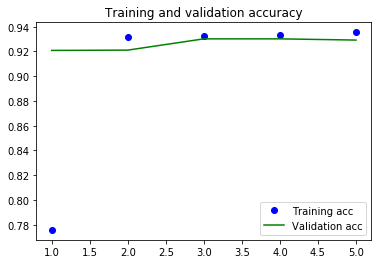

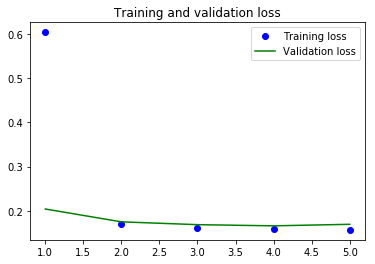

In [38]:
make_history_plot(history)

In [39]:
# Make and analyze training predictions
train_predictions = one_hot_to_category(model.predict(x_train),categories)
analyze_predictions(categories,df_train['Cat'].values,train_predictions)

Overall Accuracy: 0.936
The system change was done, and this field was removed. Please check the annoucement sent last month. --> Precision:1.0,Recall:0.913,F1:0.955
The system setting was changed, and we will restore the system setting, after that, please try it again. --> Precision:1.0,Recall:0.914,F1:0.955
The role was not changes since the change was not transferred to system.It was done, and should be work now. --> Precision:1.0,Recall:0.908,F1:0.952
The system bug and it is working now after applying patch. --> Precision:0.818,Recall:1.0,F1:0.9
Please clear your IE cache, if not work, please upgrade your windows to windows 10. --> Precision:0.978,Recall:0.912,F1:0.944
Your authorization is insufficient, please apply for the additional authorizations. --> Precision:1.0,Recall:0.898,F1:0.946
The system maintenance was completed, and it is working now. --> Precision:1.0,Recall:0.91,F1:0.953
The system setting is missing, and it is corrected after reinputting it. --> Precision:1.0,Re

In [40]:
# Make and analyze validation predictions
val_predictions = one_hot_to_category(model.predict(x_val),categories)
analyze_predictions(categories,df_val['Cat'].values,val_predictions)

Overall Accuracy: 0.929
The system change was done, and this field was removed. Please check the annoucement sent last month. --> Precision:1.0,Recall:0.877,F1:0.934
The system setting was changed, and we will restore the system setting, after that, please try it again. --> Precision:1.0,Recall:0.886,F1:0.94
The role was not changes since the change was not transferred to system.It was done, and should be work now. --> Precision:1.0,Recall:0.912,F1:0.954
The system bug and it is working now after applying patch. --> Precision:0.803,Recall:1.0,F1:0.891
Please clear your IE cache, if not work, please upgrade your windows to windows 10. --> Precision:0.966,Recall:0.887,F1:0.925
Your authorization is insufficient, please apply for the additional authorizations. --> Precision:1.0,Recall:0.956,F1:0.978
The system maintenance was completed, and it is working now. --> Precision:1.0,Recall:0.904,F1:0.95
The system setting is missing, and it is corrected after reinputting it. --> Precision:0.999